# IMPORTS

In [68]:
!pip install natsort
import os
from natsort import natsorted
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import imutils
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from math import trunc

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing google drive into google colab.

All the dataset images and ground truth boxes have been saved in different zip files



In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!unzip drive/My\ Drive/Datasets/egoHands.zip

Archive:  drive/My Drive/Datasets/egoHands.zip
replace egoHands/boundingboxes/boundingbox_1_1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data organization for YOLO

Get all the bboxes path and all the img_paths
Additionally read all the text files corresponding to the bounding boxes and append them to a list.
**bboxes** contains lists of bounding boxes, one per image

In [45]:
#Get from the unzipped dataset the list of all the paths of images and txt files
#listdir returns unsorted so use natsorted method!
bboxes_paths = natsorted(listdir_fullpath('/content/egoHands/boundingboxes'))
img_paths = natsorted(listdir_fullpath('/content/egoHands/frames'))

assert len(bboxes_paths) == len(img_paths), f"Number of bboxes_paths doesn't correspond with number of images!"

#Read all the text files and create a list of list of bounding boxes, one list per image 
bboxes = []*len(bboxes_paths)
for path in bboxes_paths:
  bboxes_it = []
  file = open(path, 'r')
  Lines = file.readlines()
  for line in Lines:
    bboxes_it.append([int(x) for x in line.split(',')])
  bboxes.append(bboxes_it)

The following cell scale down every image to have a size of 416x416 as required by the input of the network and appends the new images arrays to **scaled_images**.

Additionally it performs some modifications to the bounding boxes, transforming them from the original format to the 416x416 format and creating the list **scaled_bboxes**

In [59]:
scaled_bboxes = []*len(bboxes_paths)
scaled_images = []*len(img_paths)
for i in range(0,len(img_paths)):
  # store the original image parameters
  original_img = load_img(img_paths[i])
  width, height = original_img.size
  # load the image with the required size and calculate scale factors
  image = load_img(img_paths[i], target_size=(416, 416))
  scale_w = 416 / width 
  scale_h = 416 / height
  # for each bounding box of the image calculate its correspondent one in 416x416 format  
  bboxes_it = []
  for box in bboxes[i]:
    xleft = int(box[0] * scale_w)
    yleft = int(box[1] * scale_h)
    b_width = int(box[2] * scale_w)
    b_height = int(box[3] * scale_h)
    new_bbox = [xleft,yleft,b_width,b_height]
    bboxes_it.append(new_bbox)
  scaled_bboxes.append(bboxes_it)
  # convert the image to the array format required by the CNN
  image = img_to_array(image)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  scaled_images.append(image)

**TESTING** :
In the following cell, some testing can be performed to visualize the scaled down version of the image and the corresponding scaled down bounding box. Just chang the variable *number* to see different results

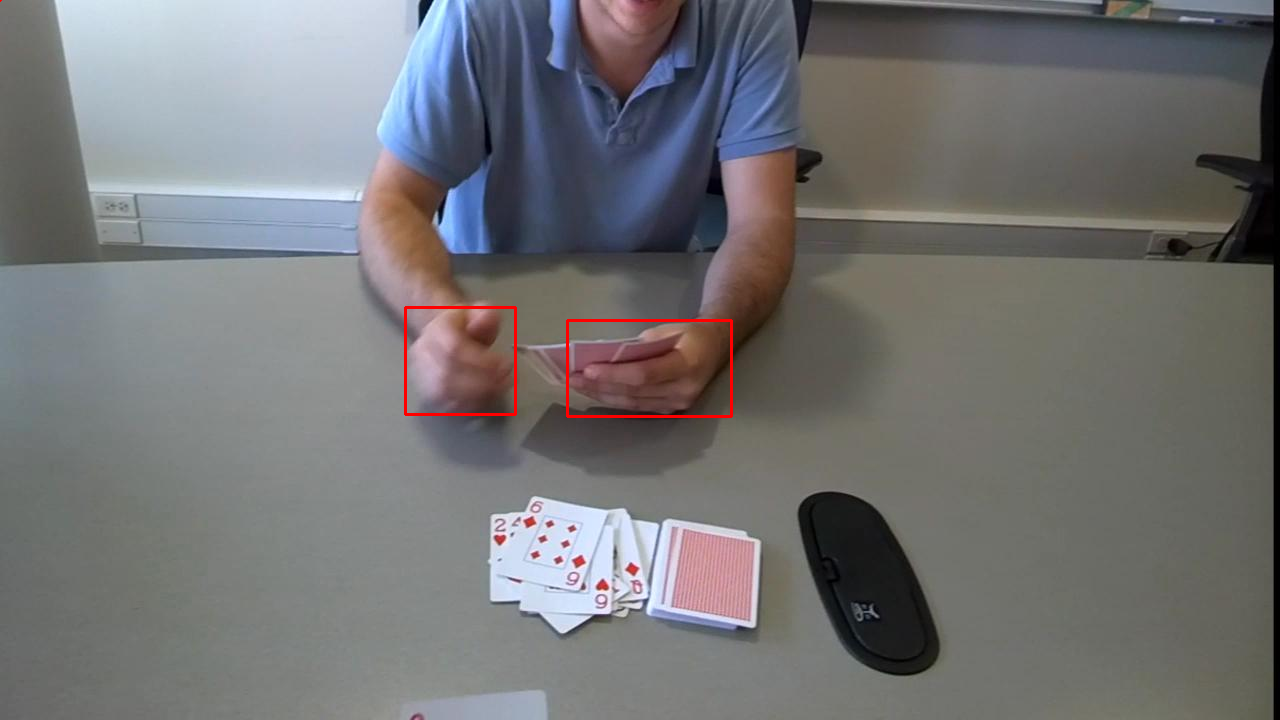

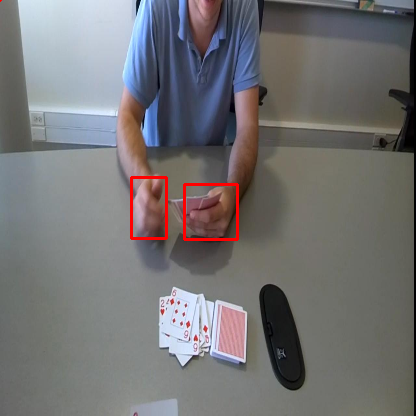

In [65]:
number = 1000

image = cv2.imread(img_paths[number])
      
# Drawing the regions in the Image
for (x, y, w, h) in bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
cv2_imshow(image) 

image = cv2.imread(img_paths[number])
      
# Resizing the Image
image = cv2.resize(image,(416,416))

# Drawing the regions in the Image
for (x, y, w, h) in scaled_bboxes[number]:
  cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
  
cv2_imshow(image)

Now create the grid of cells that Yolo analyzes.
The size of the grid is 8x8 meaning that each cell will have a size of 52x52.

For each bounding box calculate its center, the center will be the grid at which the bounding box is associated.
Each grid cell has a bounding box associated with it (zero if no bounding box). The bounding box has this form [P, Ox, Oy, W, H]:


*   P = probability that there's a hand (always 1 since we are taking ground truth boxes)
*   Ox = X center of the bounding box w.r.t to that grid, each grid has coordinates defined by (0,0) and (1,1) being respectively the up-left and down-rigth corner of such grid
*   Oy = Y center with same reasoning as above
*   W = width of the bounding box w.r.t the grid size
*   H = height of the bounding box w.r.t. the grid size

So, as an example, a bounding box b = [208,208,104,104] will be associated to the cell at row = 3 and column = 3 and become b_new = [1 ,0.5 ,0.5 , 2, 2]



In [77]:
S = 8
grid_size = 416/S
Y_net = np.zeros((len(scaled_bboxes),8,8,5))
for i in range(0,len(scaled_bboxes)):
  for (x, y, w, h) in scaled_bboxes[i]:
    ox = x + w/2
    oy = y + h/2
    grid_col = trunc(ox/grid_size) - 1
    grid_row = trunc(oy/grid_size) - 1
    ox_cell = (ox - (grid_col + 1)*grid_size)/grid_size
    oy_cell = (oy - (grid_row + 1)*grid_size)/grid_size
    grid_width = w/grid_size
    grid_heigth = h/grid_size
    y = [1,ox_cell,oy_cell,grid_width,grid_heigth]
    Y_net[i][grid_row][grid_col] = y